<a href="https://colab.research.google.com/github/AbdulQadir8/Langraph-Tutorial-Projects/blob/master/langraph_tutorial_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith langchain_google_genai

In [2]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get("GEMINI_API_KEY")

In [3]:
from langchain_google_genai import GoogleGenerativeAI

llm = GoogleGenerativeAI(
    model='gemini-1.5-flash',
    max_retries=2,
    api_key=gemini_api_key
)

llm.invoke('greet me')

'Hello there! How can I help you today? \n'

## Part 1: Build a Basic Chatbot

We'll first create a simple chatbot using LangGraph. This chatbot will respond directly to user messages. Though simple, it will illustrate the core concepts of building with LangGraph. By the end of this section, you will have a built rudimentary chatbot.

Start by creating a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add `nodes` to represent the llm and functions our chatbot can call and `edges` to specify how the bot should transition between these functions.

In [4]:
from typing import Annotated
from typing_extensions import TypedDict


from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
  # Messages have the type "list". The `add_messages` function
  # in the annotation defines how this state key should be updated
  # (in this case, it appends messages to the list, rather than overwriting them)
  messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [5]:
# Example usage of add_messages
new_messages_1 = [{"role": "user", "content": "Hello"}]
new_messages_2 = [{"role": "ai", "content": "Hi there!"}]

updated_state_1 = add_messages(new_messages_1, new_messages_2)


print("Updated State 1:", updated_state_1)

# from typing import Annotated
# from typing_extensions import TypedDict
# from langgraph.graph import StateGraph

# class State(TypedDict):
#     messages: Annotated[list, add_messages]

# builder = StateGraph(State)
# builder.add_node("chatbot", lambda state: {"messages": [("assistant", "Hello")]})
# builder.set_entry_point("chatbot")
# builder.set_finish_point("chatbot")
# graph = builder.compile()
# graph.invoke({"messages": [{"role": "user", "content": "Hello"}]})

Updated State 1: [HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='81512815-6c41-4670-bd52-ae214f20dace'), AIMessage(content='Hi there!', additional_kwargs={}, response_metadata={}, id='5f9cee5b-7a07-466d-aca5-161dbc1b1bef')]


So now our graph knows two things:

1. Every `node` we define will receive the current `State` as input and return a value that updates that state.
2. `messages` will be _appended_ to the current list, rather than directly overwritten. This is communicated via the prebuilt [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) function in the `Annotated` syntax.

Next, add a "`chatbot`" node. Nodes represent units of work. They are typically regular python functions.

In [6]:
def chatbot(state: State):
  return {"messages":[llm.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot",chatbot)

**Notice** how the `chatbot` node function takes the current `State` as input and returns a dictionary containing an updated `messages` list under the key "messages". This is the basic pattern for all LangGraph node functions.

The `add_messages` function in our `State` will append the llm's response messages to whatever messages are already in the state.

Next, add an `entry` point. This tells our graph **where to start its work** each time we run it.

In [7]:
graph_builder.add_edge(START, "chatbot")

Similarly, set a `finish` point. This instructs the graph **"any time this node
is run, you can exit."**

In [8]:
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw"

---

methods, like `draw_ascii` or `draw_png`. The `draw` methods each require additional dependencies.

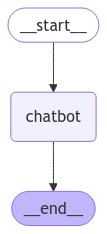

In [10]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  # This requires some extra dependencies and is optional
  pass



In [11]:
for event in graph.stream({"messages":[("user","I am Abdul Qadir")]}):
  print("EVENT: ",list(event.values())[0]["messages"][-1])

EVENT:  It's nice to meet you, Abdul Qadir! 😊 

Is there anything I can help you with today? I'm here to assist with any questions or tasks you might have. 



In [12]:
def stream_graph_updates(user_input: str):
  for event in graph.stream({"messages": [("user", user_input)]}):
    for value in event.values():
      print("Assistant", value["messages"][-1])

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit","exit","q"]:
      print("Good bye!")
      break
    stream_graph_updates(user_input)
  except:
    # fallback if input is not available
    user_input = "What do you know about LangGraph?"
    print("User: "+ user_input)
    stream_graph_updates(user_input)
    break

User: Hi 
Assistant Hi there! How can I help you today? 

User: its me Adbul Qadir
Assistant Hello Abdul Qadir! 👋  It's nice to hear from you. What can I do for you today? 😊 

User: Do you know my name
Assistant As an AI, I do not have memory of past conversations or personal information about individuals. Therefore, I do not know your name. 

If you would like to tell me your name, I would be happy to learn it! 😊 

User: Can you tell me about Al-Kundi?
Assistant ## Al-Kindi: The "Philosopher of the Arabs"

**Al-Kindi**, also known as **"The Philosopher of the Arabs"**, was a prominent Arab polymath who lived in the 9th century CE (circa 801-873). He was a philosopher, scientist, mathematician, physician, astrologer, and musician, making significant contributions to various fields of knowledge. 

**Here are some key aspects of his life and work:**

* **Early Life:** Al-Kindi was born in Kufa, Iraq, into a wealthy and influential family. He received a comprehensive education in Baghdad,